In [56]:
import numpy as np
import pandas as pd
import torch
import os

import matplotlib.pyplot as plt
from PIL import Image

import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split,Dataset
import torch.nn as nn
import torch.nn.functional as F

In [57]:
cuda = True if torch.cuda.is_available() else False
    
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor    

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [58]:
cuda = True if torch.cuda.is_available() else False

In [91]:
train_path=r"C:/Users/MJ/Desktop/Music_Scale_Recognition/music_train"
test_path=r"C:/Users/MJ/Desktop/Music_Scale_Recognition/music_test"
transform=transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])


In [138]:
class MusicDataset(Dataset):
    def __init__(self,root_dir,transform=None,is_train=True):

        super().__init__()
        self.train_truth=pd.read_csv("C:/Users/MJ/Desktop/Music_Scale_Recognition/train_truth.csv")
        self.root_dir=root_dir
        self.transform=transform
        self.is_train=is_train
        if (is_train):
            self.path=self.train_truth['filename']
            
        else:
            self.path=os.listdir(root_dir)


    def __len__(self):
        return len(self.train_truth)
    
    

    def __getitem__(self,idx):
        img_path = os.path.join(self.root_dir, self.path[idx])
        img = Image.open(img_path)
        
        if (self.transform):
            img=self.transform(img)

        if (self.is_train):
            label=torch.tensor(int(self.train_truth['category'][idx]))
            return img,label
        else:
            return img

In [139]:
trainset=MusicDataset(train_path,transform,is_train=True)
train_size=len(trainset)
testset=MusicDataset(test_path,transform,is_train=False)

In [140]:
train_dl=DataLoader(trainset,shuffle=False, batch_size=10)
test_dl=DataLoader(testset,shuffle=False, batch_size=10)

In [77]:
class CNN(nn.Module):
    def __init__(self,in_channels=4,num_classes=88):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=8,kernel_size=3,stride=1,padding=1),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*32*32, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
        

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [78]:
model=CNN(4,88)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)


In [89]:
epochs=10
best_accu = 0.0 
train_losses = []
val_losses = []
train_accu = []
val_accu = []

model.train()
for epoch in range(epochs):
        train_loss=0
        accu=0
        for batch,(data, target) in enumerate(train_dl):
                
                optim.zero_grad()
                out = model(data)
                _, y_pred_tag = torch.max(out, dim = 1)

                loss = criterion(out, target)
                loss.backward()
                
                optim.step()

                train_loss += loss.item()*data.size(0) #loss.item is batch loss mean
                correct=torch.sum(y_pred_tag == target).item()
                accu += correct
                
            
        train_loss=train_loss/train_size
        accu=accu/train_size
        train_losses.append(train_loss)
        train_accu.append(accu)
                

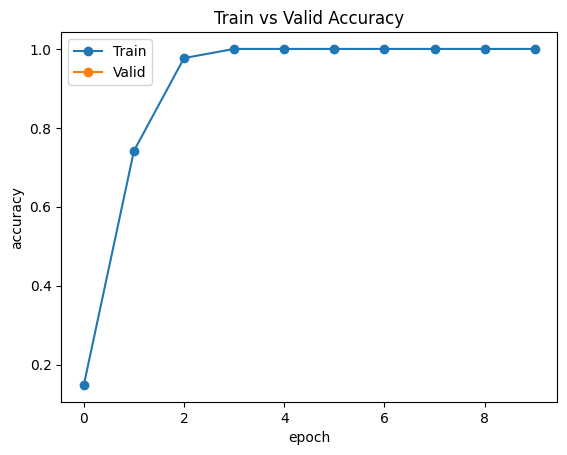

In [87]:
plt.plot(train_accu,'-o')
plt.plot(val_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

In [142]:
model.eval()

output=[]
with torch.no_grad():
    for data, target in enumerate(test_dl):
        out=model(data)
        _, y_pred_tag = torch.max(out, dim = 1)
        output.extend(y_pred_tag.numpy().tolist())
    print(output)

        # output.append(y_pred_tag)

TypeError: conv2d() received an invalid combination of arguments - got (int, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!int!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!int!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [ ]:
sample_submission=pd.read_csv(r"C:/Users/MJ/Desktop/Music_Scale_Recognition/sample_truth.csv")
sample_submission['y']=output
sample_submission.to_csv(r"C:/Users/MJ/Desktop/Music_Scale_Recognition/sample_truth.csv",index=False)

In [99]:
# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()        